In [263]:
from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as fn
from sklearn.utils import shuffle
import torch.optim as optim
import torch
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
m = 10000

## dataset -> list of tuples, first is human and second machine
## human vocab -> letters/numbers to index
## machine_vocab -> numbers and dash to index
## inv machine vocab -> index to numbers and dash

dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 16553.47it/s]


In [8]:
max_human_length = 30
max_machine_length = 10
## truncates if smaller than length and pads if shorter. also fills in with unk
## x is np array for each training example as a list of indexes. Same for y
X, Y = preprocess_data(dataset, human_vocab, machine_vocab, max_human_length, max_machine_length)

In [256]:
class Encoder(nn.Module):
    
    def __init__(self, human_vocab_size):
        super(Encoder, self).__init__()
        
        self.human_embedding = nn.Embedding(human_vocab_size, 50)
        self.pre_attention_bilstm = nn.LSTM(50, 32, bidirectional=True)
        
    def forward(self, human_indexes):
        human_embeds = self.human_embedding(human_indexes)
        human_embeds = human_embeds.unsqueeze(1)
        pre_lstm, _ = self.pre_attention_bilstm(human_embeds)
        return pre_lstm
    
class Decoder(nn.Module):
    
    """
    Doesn't actually take in previous character as likely not very correlated.
    Most of the correlation lies within the encoder vectors
    """
    
    def __init__(self):
        super(Decoder, self).__init__()
        self.hidden_size = 64
        ## 128 b/c concat is 128 and 10 b/c machine output is 10
        self.densor1 = nn.Linear(128, 10)
        self.densor2 = nn.Linear(10, 1)
        self.lstm = nn.LSTM(64, 64)
        self.dense_out = nn.Linear(64, 11)
        
    def forward(self, previous_hidden, previous_cell, encodings):
        previous_hidden_expanded = previous_hidden.repeat(30, 1, 1)
        concat_vector = torch.cat((previous_hidden_expanded, encodings), 2)
        densor1_out =  fn.tanh(self.densor1(concat_vector))
        densor2_out = fn.relu(self.densor2(densor1_out))
        attention_weights = fn.softmax(densor2_out, 0)
        encodings_view = encodings.view(1, 30, 64)
        attention_weights_view = attention_weights.view(1, 1, 30)
        weighted_encodings = torch.bmm(attention_weights_view, encodings_view)
        lstm_out, (h_out, c_out) = self.lstm(weighted_encodings, (previous_hidden, previous_cell))
        out = self.dense_out(lstm_out).squeeze(0)
        return out, h_out, c_out
        
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [257]:
encoder = Encoder(len(human_vocab))
decoder = Decoder()
n_epochs = 1
learning_rate = 0.001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [261]:
total_loss = 0
total_i = 0
for epoch in range(n_epochs):
    X, Y = shuffle(X, Y)
    for i in range(len(X)):
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        human_date_indexes = X[i]
        machine_date_indexes = Y[i]
        
        x = torch.LongTensor(human_date_indexes).to(device)
        
        pre_lstm_vectors = encoder(x)
        
        previous_hidden = decoder.initHidden()
        previous_cell = decoder.initHidden()
        
        loss = 0
        for machine_index in machine_date_indexes:
            out, previous_hidden, previous_cell = decoder(previous_hidden, previous_cell, pre_lstm_vectors)
            actual = torch.LongTensor([machine_index]).to(device)
            loss += criterion(out, actual)
            
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
        
        total_i += 1
        total_loss += loss.item()
        
        if (epoch * len(X) + i) % 250 == 0:
            print("{0}/{1}".format(epoch * len(X) + i, n_epochs*len(X)))
            avg_loss = total_loss / total_i
            print("Avg Loss: {}".format(avg_loss))
            losses.append(avg_loss)

0/10000
Avg Loss: 7.082835674285889
250/10000
Avg Loss: 8.112926200091602
500/10000
Avg Loss: 7.844023532734184
750/10000
Avg Loss: 7.612804451572911
1000/10000
Avg Loss: 7.839398875936761
1250/10000
Avg Loss: 7.67209888724305
1500/10000
Avg Loss: 7.480597668532766
1750/10000
Avg Loss: 7.3000361547001695
2000/10000
Avg Loss: 7.128380452853808
2250/10000
Avg Loss: 7.002545619794709
2500/10000
Avg Loss: 6.879469569565439
2750/10000
Avg Loss: 6.762056731475739
3000/10000
Avg Loss: 6.640475864809221
3250/10000
Avg Loss: 6.5198423103052665
3500/10000
Avg Loss: 6.415465170606414
3750/10000
Avg Loss: 6.309648447149883
4000/10000
Avg Loss: 6.215865633899466
4250/10000
Avg Loss: 6.128431861750015
4500/10000
Avg Loss: 6.028414438417609
4750/10000
Avg Loss: 5.94368282573345
5000/10000
Avg Loss: 5.857298819476713
5250/10000
Avg Loss: 5.76725482839649
5500/10000
Avg Loss: 5.677036398487771
5750/10000
Avg Loss: 5.581902072846713
6000/10000
Avg Loss: 5.495137971046666
6250/10000
Avg Loss: 5.393912849

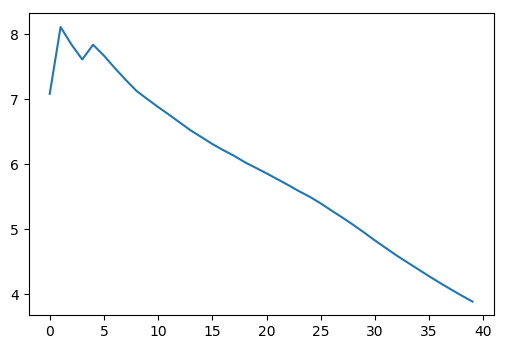

In [264]:
plt.plot(losses)

In [266]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 
            'Tue 10 Jul 2007', 'Saturday May 9 2018', 
            'March 3 2001', 'March 3rd 2001', '1 March 2001']
encoder.eval()
decoder.eval()
with torch.no_grad():
    for example in EXAMPLES:

        source = string_to_int(example, max_human_length, human_vocab)

        x = torch.LongTensor(source).to(device)
        
        pre_lstm_vectors = encoder(x)
        
        previous_hidden = decoder.initHidden()
        previous_cell = decoder.initHidden()
        
        prediction = []
        for _ in range(max_machine_length):
            out, previous_hidden, previous_cell = decoder(previous_hidden, previous_cell, pre_lstm_vectors)
            prediction.append(out.argmax().item())

        output = [inv_machine_vocab[int(i)] for i in prediction]

        print("source:", example)
        print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2099-04-05
source: 21th of August 2016
output: 2016-08-21
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-00
source: 1 March 2001
output: 2001-03-01


## Visualize Weights